# Regression Analysis Step-by-step

## Contents:
1. Overview
    - Machine learning approaches
    - Example data
2. Exploratory Data Analysis (identifying features to remove before ML)
    - Feature missingness
    - Feature correlation
3. Machine learning (using all features)
    - Model hyper-parameter tuning
    - Model performance on nested cross-validation
4. Machine learning (using feature selection)
    - BorutaShap feature selection
    - Model hyper-parameter tuning
    - Model performance on nested cross-validation
5. Interpreting model decision-making
    - SHAP interpretation

## Overview

## Machine Learning Approaches
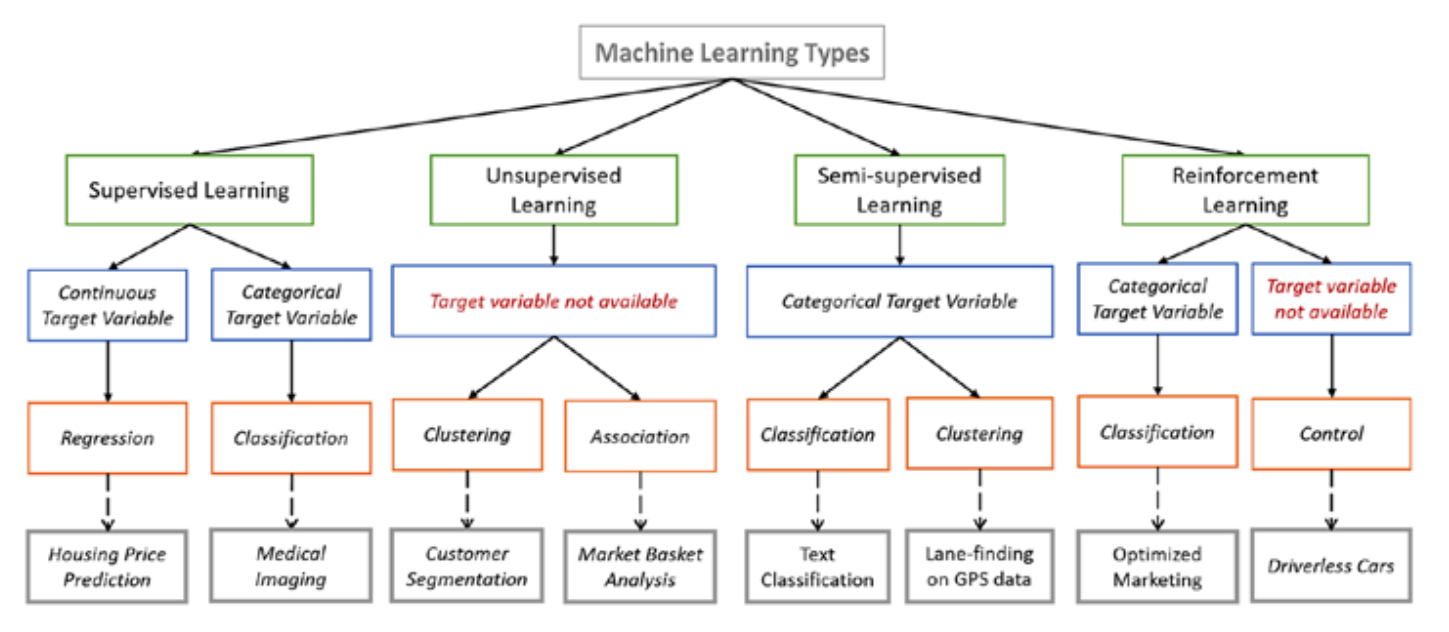

**Example Data**

Example academic data taken from a Kaggle Competion (Kaggle is a website that hosts data science competitions). 
The dataset has been posted by a user on Kaggle (and so is not studied or verified in where it has been collected from), however it was posted with a similar aim:

*The dataset was created in a project that aims to contribute to the reduction of academic dropout and failure in higher education, by using machine learning techniques to identify students at risk at an early stage of their academic path, so that strategies to support them can be put into place. The dataset includes information known at the time of student enrollment – academic path, demographics, and social-economic factors. The problem is formulated as a three category classification task (dropout, enrolled, and graduate) at the end of the normal duration of the course.*


- A pdf accompanies the dataset detailing encoding of all qualitative variables ('Feature information.pdf')

- The dataset has a categorical target variable that I will convert to a continuous variable for sake of having a regression example

**References:**

https://www.kaggle.com/datasets/ankanhore545/dropout-or-academic-success

https://zenodo.org/record/5777340#.YuqF0OzMJ6q

In [1]:
#Load packages:

import pandas as pd #Dataframe handling package
import numpy as np #Array datatype handling package
from sklearn import metrics, preprocessing, model_selection #Machine learning package
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score, mean_absolute_error, max_error


import sys #Editting inside sklearn for package compatibility (only needed inside my local environment for conflciting package versions)
import sklearn.neighbors._base  
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base

import matplotlib.pyplot as plt #Plotting package
%matplotlib inline
import seaborn as sns #Wrapper plotting package on top of matplotlib
import missingno as msno #Missing data visualisation package (optional)


from missingpy import MissForest #Feature imputation package (not sure if worth using for this case or replacing missing values with zeros)
from BorutaShap import BorutaShap #Feature selection package

import xgboost as xgb
from catboost import CatBoostRegressor

from skopt import BayesSearchCV  #sklearn hyper-parameter tuning package (bayesian optimisation method)
import shap #Package for interpreting machine learning model decision making

seed = 0 #setting the same starting point for randomised entropy inside all functions

data = pd.read_csv("Academic_Data.csv", header=0, sep=",")

## Exploratory Data Analysis:

In [2]:
data.shape #Viewing total number of rows and columns

(4424, 37)

In [3]:
data.head() #Viewing the first 5 rows

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


In [4]:
data['Target'].unique() #viewing classes in target variable to convert into a continuous scale for regression analysis

array(['Dropout', 'Graduate', 'Enrolled'], dtype=object)

In [5]:
#Target variable needs to be converted to scores
data["target_encoded"] = data["Target"].map({"Dropout": 1, "Enrolled":0.5, "Graduate": 0})
Y = data["target_encoded"]
dt = data.drop(["Target"], 1)

## Feature missingness:

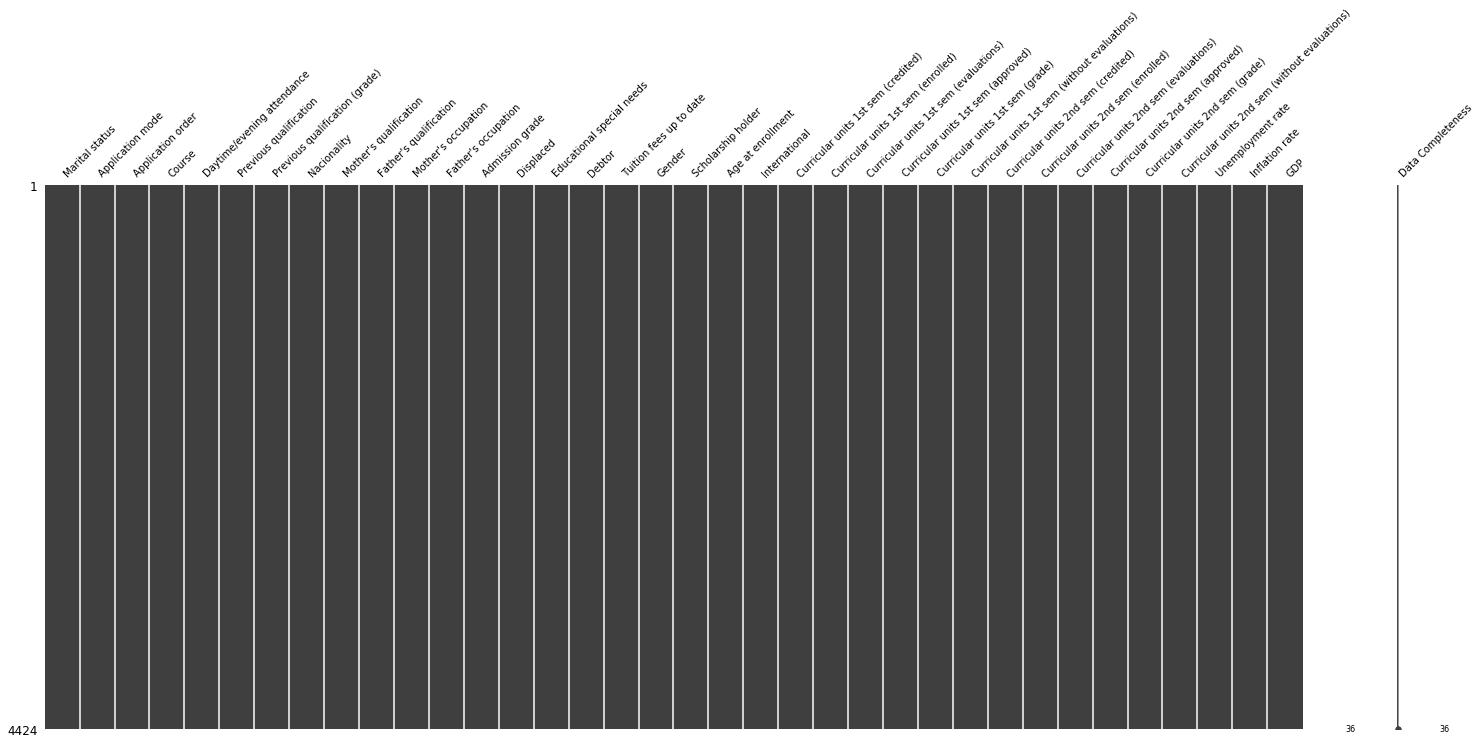

In [6]:
#Plotting available in missingno package:
data_drop = dt.drop(["target_encoded",], 1)
msno.matrix(data_drop, labels=True, fontsize=10) #black indicates completeness (y axis is the rows numbered 1 to 4424)
#white lines would indicate missing rows but the features are entirely complete

<BarContainer object of 36 artists>

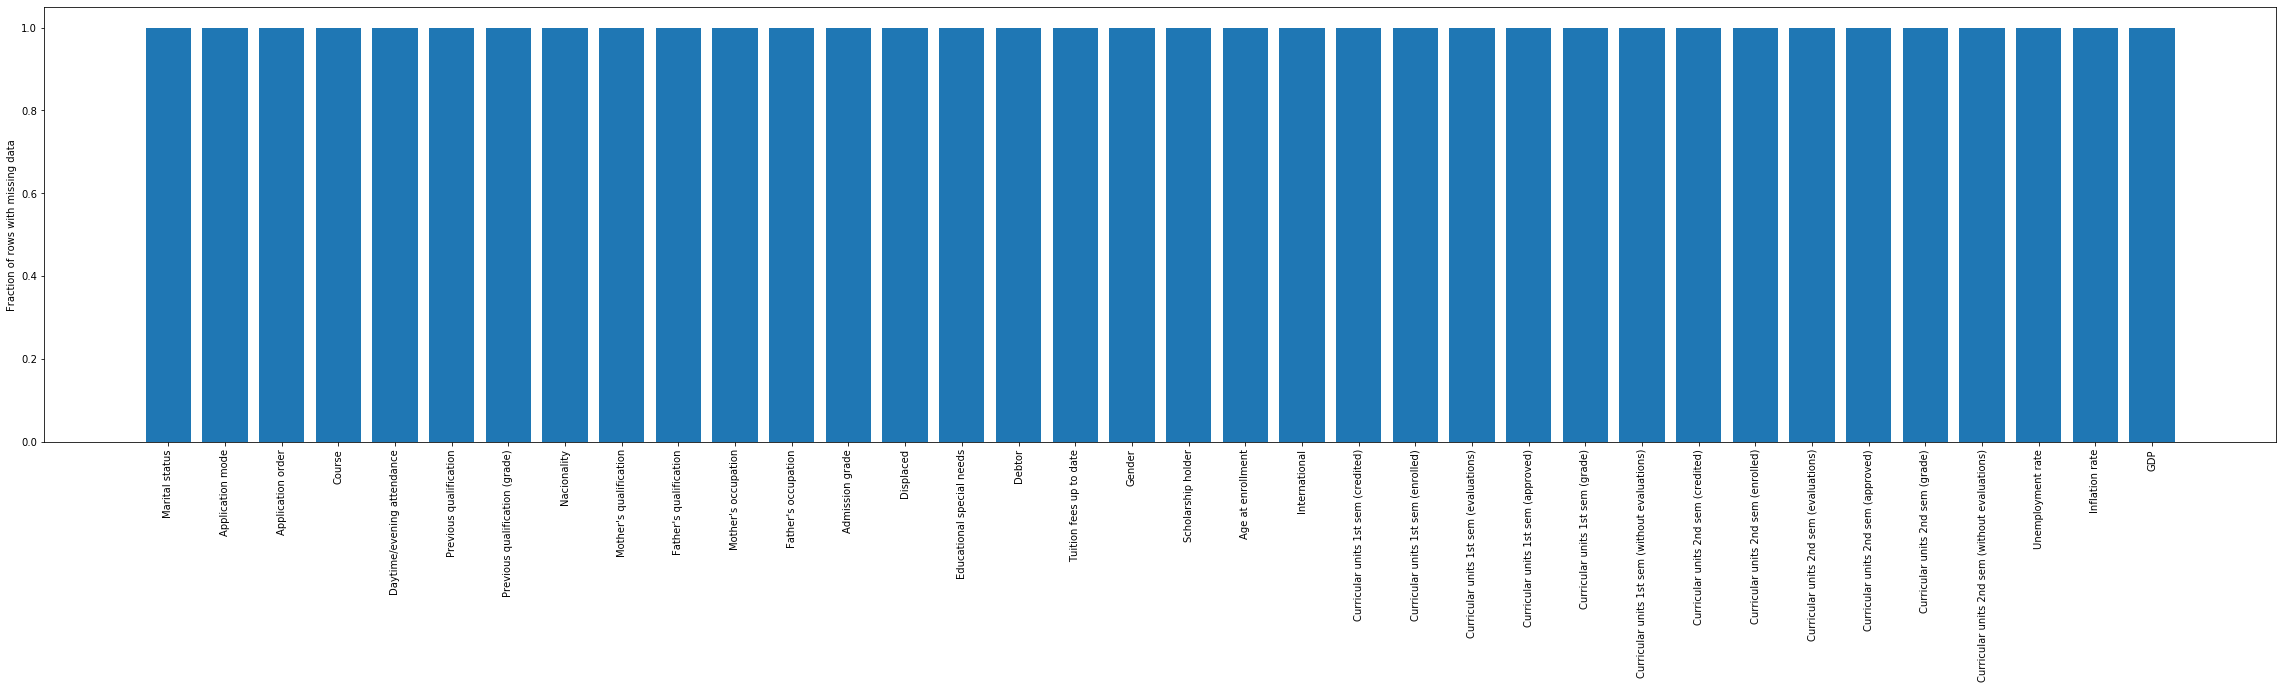

In [7]:
#Matplotlib version of plotting data missingess (features are entirely complete)
data_drop = dt.drop(["target_encoded",], 1)
null_counts = data_drop.notnull().sum() / len(data_drop)
plt.figure(figsize=(40, 8))
plt.xticks(np.arange(len(null_counts)) + 0.0, null_counts.index, rotation="vertical")
plt.ylabel("Fraction of rows with missing data")
plt.bar(np.arange(len(null_counts)), null_counts)
#plt.savefig("missingness.png", format="png", dpi=300, bbox_inches="tight")

This example has no missing values. However, if the data had missing values the code to remove features > 25% missing would be:

```
percent_missing = dt.isnull().sum() * 100 / len(dt)
missing_value_df = pd.DataFrame({"column_name": dt.columns, "percent_missing": percent_missing})
selection = missing_value_df[missing_value_df["percent_missing"] < 25.00]
df = dt[list(selection["column_name"])]
```

Imputing any missing values would be:

```
#Random forest imputation:

imputer = MissForest(random_state=seed)
X = pd.DataFrame(imputer.fit_transform(X), index=df.index, columns=df.columns)


#Or replacing missing values with zeros
df.replace(np.nan, 0, inplace=True)
```

XGBoost and Catboost can accept missing values (and so can run without feature imputation if needed)

## Feature Correlation:

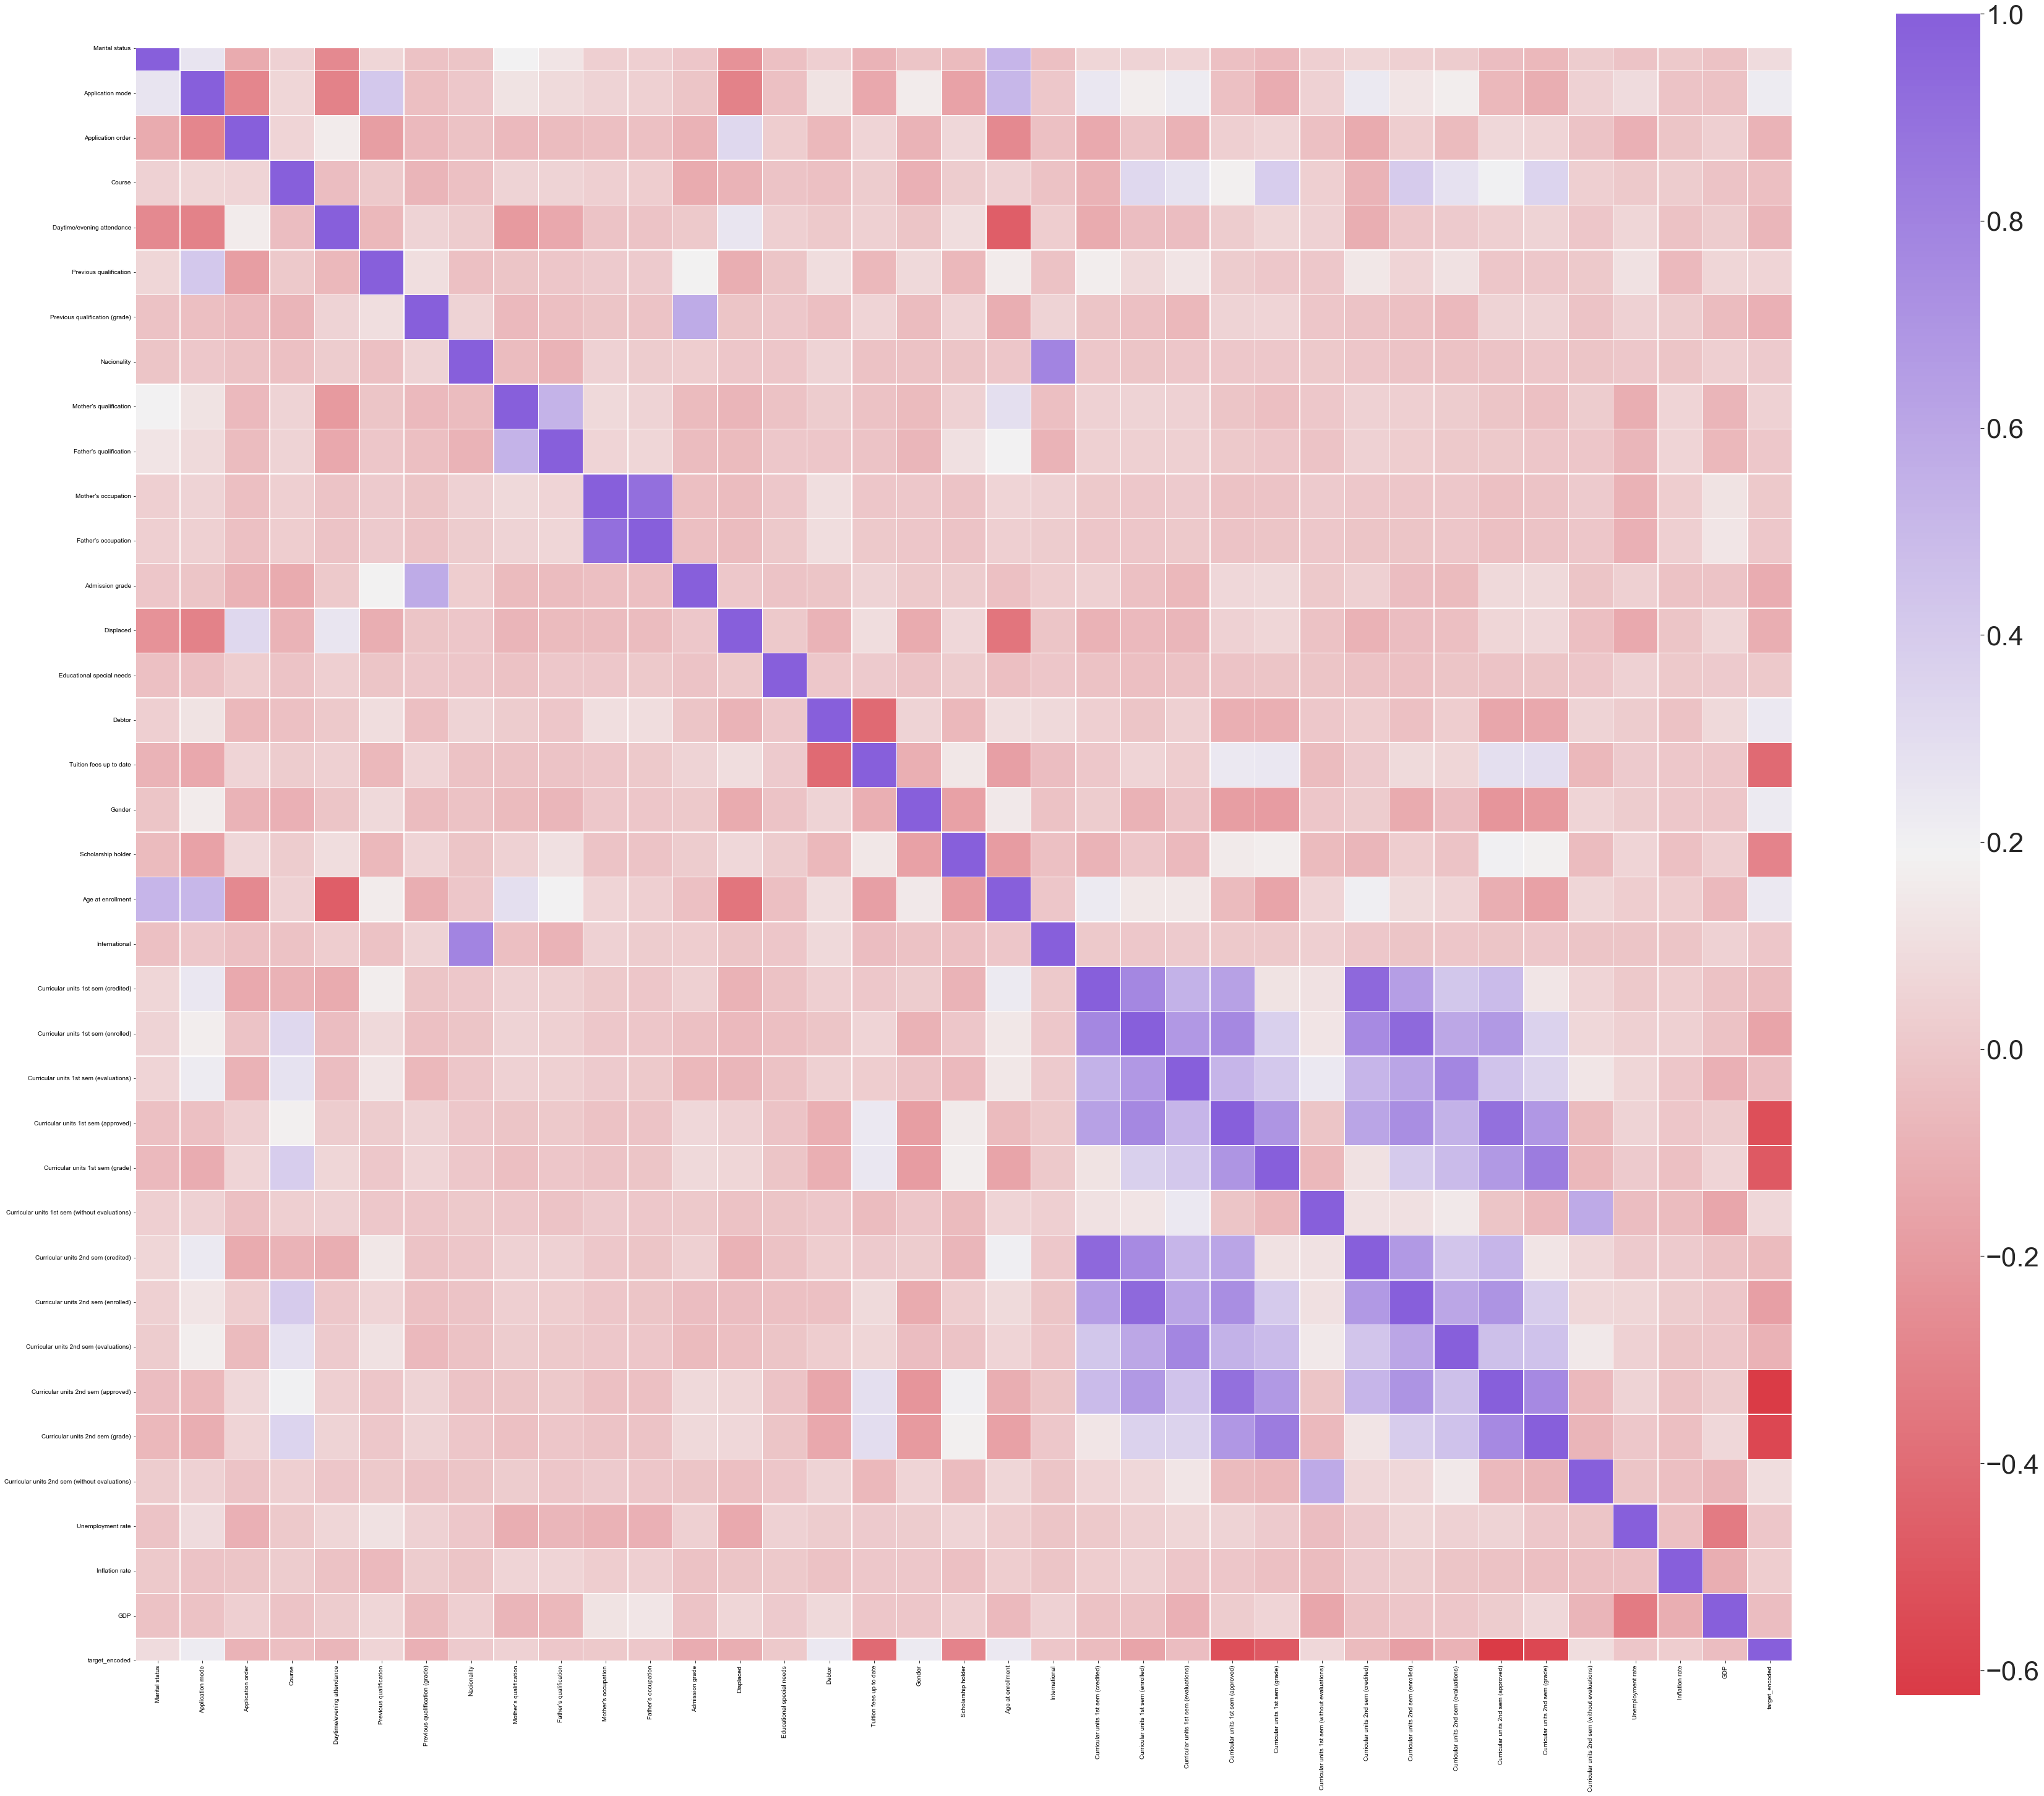

In [8]:
Xcor = dt

corr = Xcor.corr(method="pearson")

f, ax = plt.subplots(figsize=(60, 50))

cmap = sns.diverging_palette(10, 275, as_cmap=True)
sns.set(font_scale=4)

htmap = sns.heatmap(
    corr,
    cmap=cmap,
    square=True,
    xticklabels=True,
    yticklabels=True,
    linewidths=0.5,
    annot_kws={"fontsize":8},
    ax=ax)

figure = htmap.get_figure()

In [9]:
#Identifying the highly correlating features to remove one feature from each correlating pair 
Xcor = dt
Xcor = pd.DataFrame(data=Xcor, columns=dt.columns)
corr = Xcor.corr(method="pearson").abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
print("Dropped features with > 0.9 correlation:", to_drop)

Dropped features with > 0.9 correlation: ["Father's occupation", 'Curricular units 2nd sem (credited)', 'Curricular units 2nd sem (enrolled)', 'Curricular units 2nd sem (approved)']


In [10]:
selected_columns = dt.drop(dt[to_drop], axis=1)
#Cleaned features that are complete and not highly correlating:
list(selected_columns)

['Marital status',
 'Application mode',
 'Application order',
 'Course',
 'Daytime/evening attendance',
 'Previous qualification',
 'Previous qualification (grade)',
 'Nacionality',
 "Mother's qualification",
 "Father's qualification",
 "Mother's occupation",
 'Admission grade',
 'Displaced',
 'Educational special needs',
 'Debtor',
 'Tuition fees up to date',
 'Gender',
 'Scholarship holder',
 'Age at enrollment',
 'International',
 'Curricular units 1st sem (credited)',
 'Curricular units 1st sem (enrolled)',
 'Curricular units 1st sem (evaluations)',
 'Curricular units 1st sem (approved)',
 'Curricular units 1st sem (grade)',
 'Curricular units 1st sem (without evaluations)',
 'Curricular units 2nd sem (evaluations)',
 'Curricular units 2nd sem (grade)',
 'Curricular units 2nd sem (without evaluations)',
 'Unemployment rate',
 'Inflation rate',
 'GDP',
 'target_encoded']

## Feature Distributions:
- Checking feature distributions can help to decide if feature scaling is needed (also if it is needed can depend on the model type used)
- Feature distributions should be compared between the training data and test data. And also the whole training dataset fit to a model against any new data that model then predicts (to check if the features meet the independent and identically distributed assumptions - i.i.d assumptions - that many models make)
- If there are significant differences in the distributions, the model will learn one distribution and then may not generalise well to new data with patterns it hasn't learnt/been exposed to previously.

Text(0.5, 1.02, 'Training Data Univariate Plots')

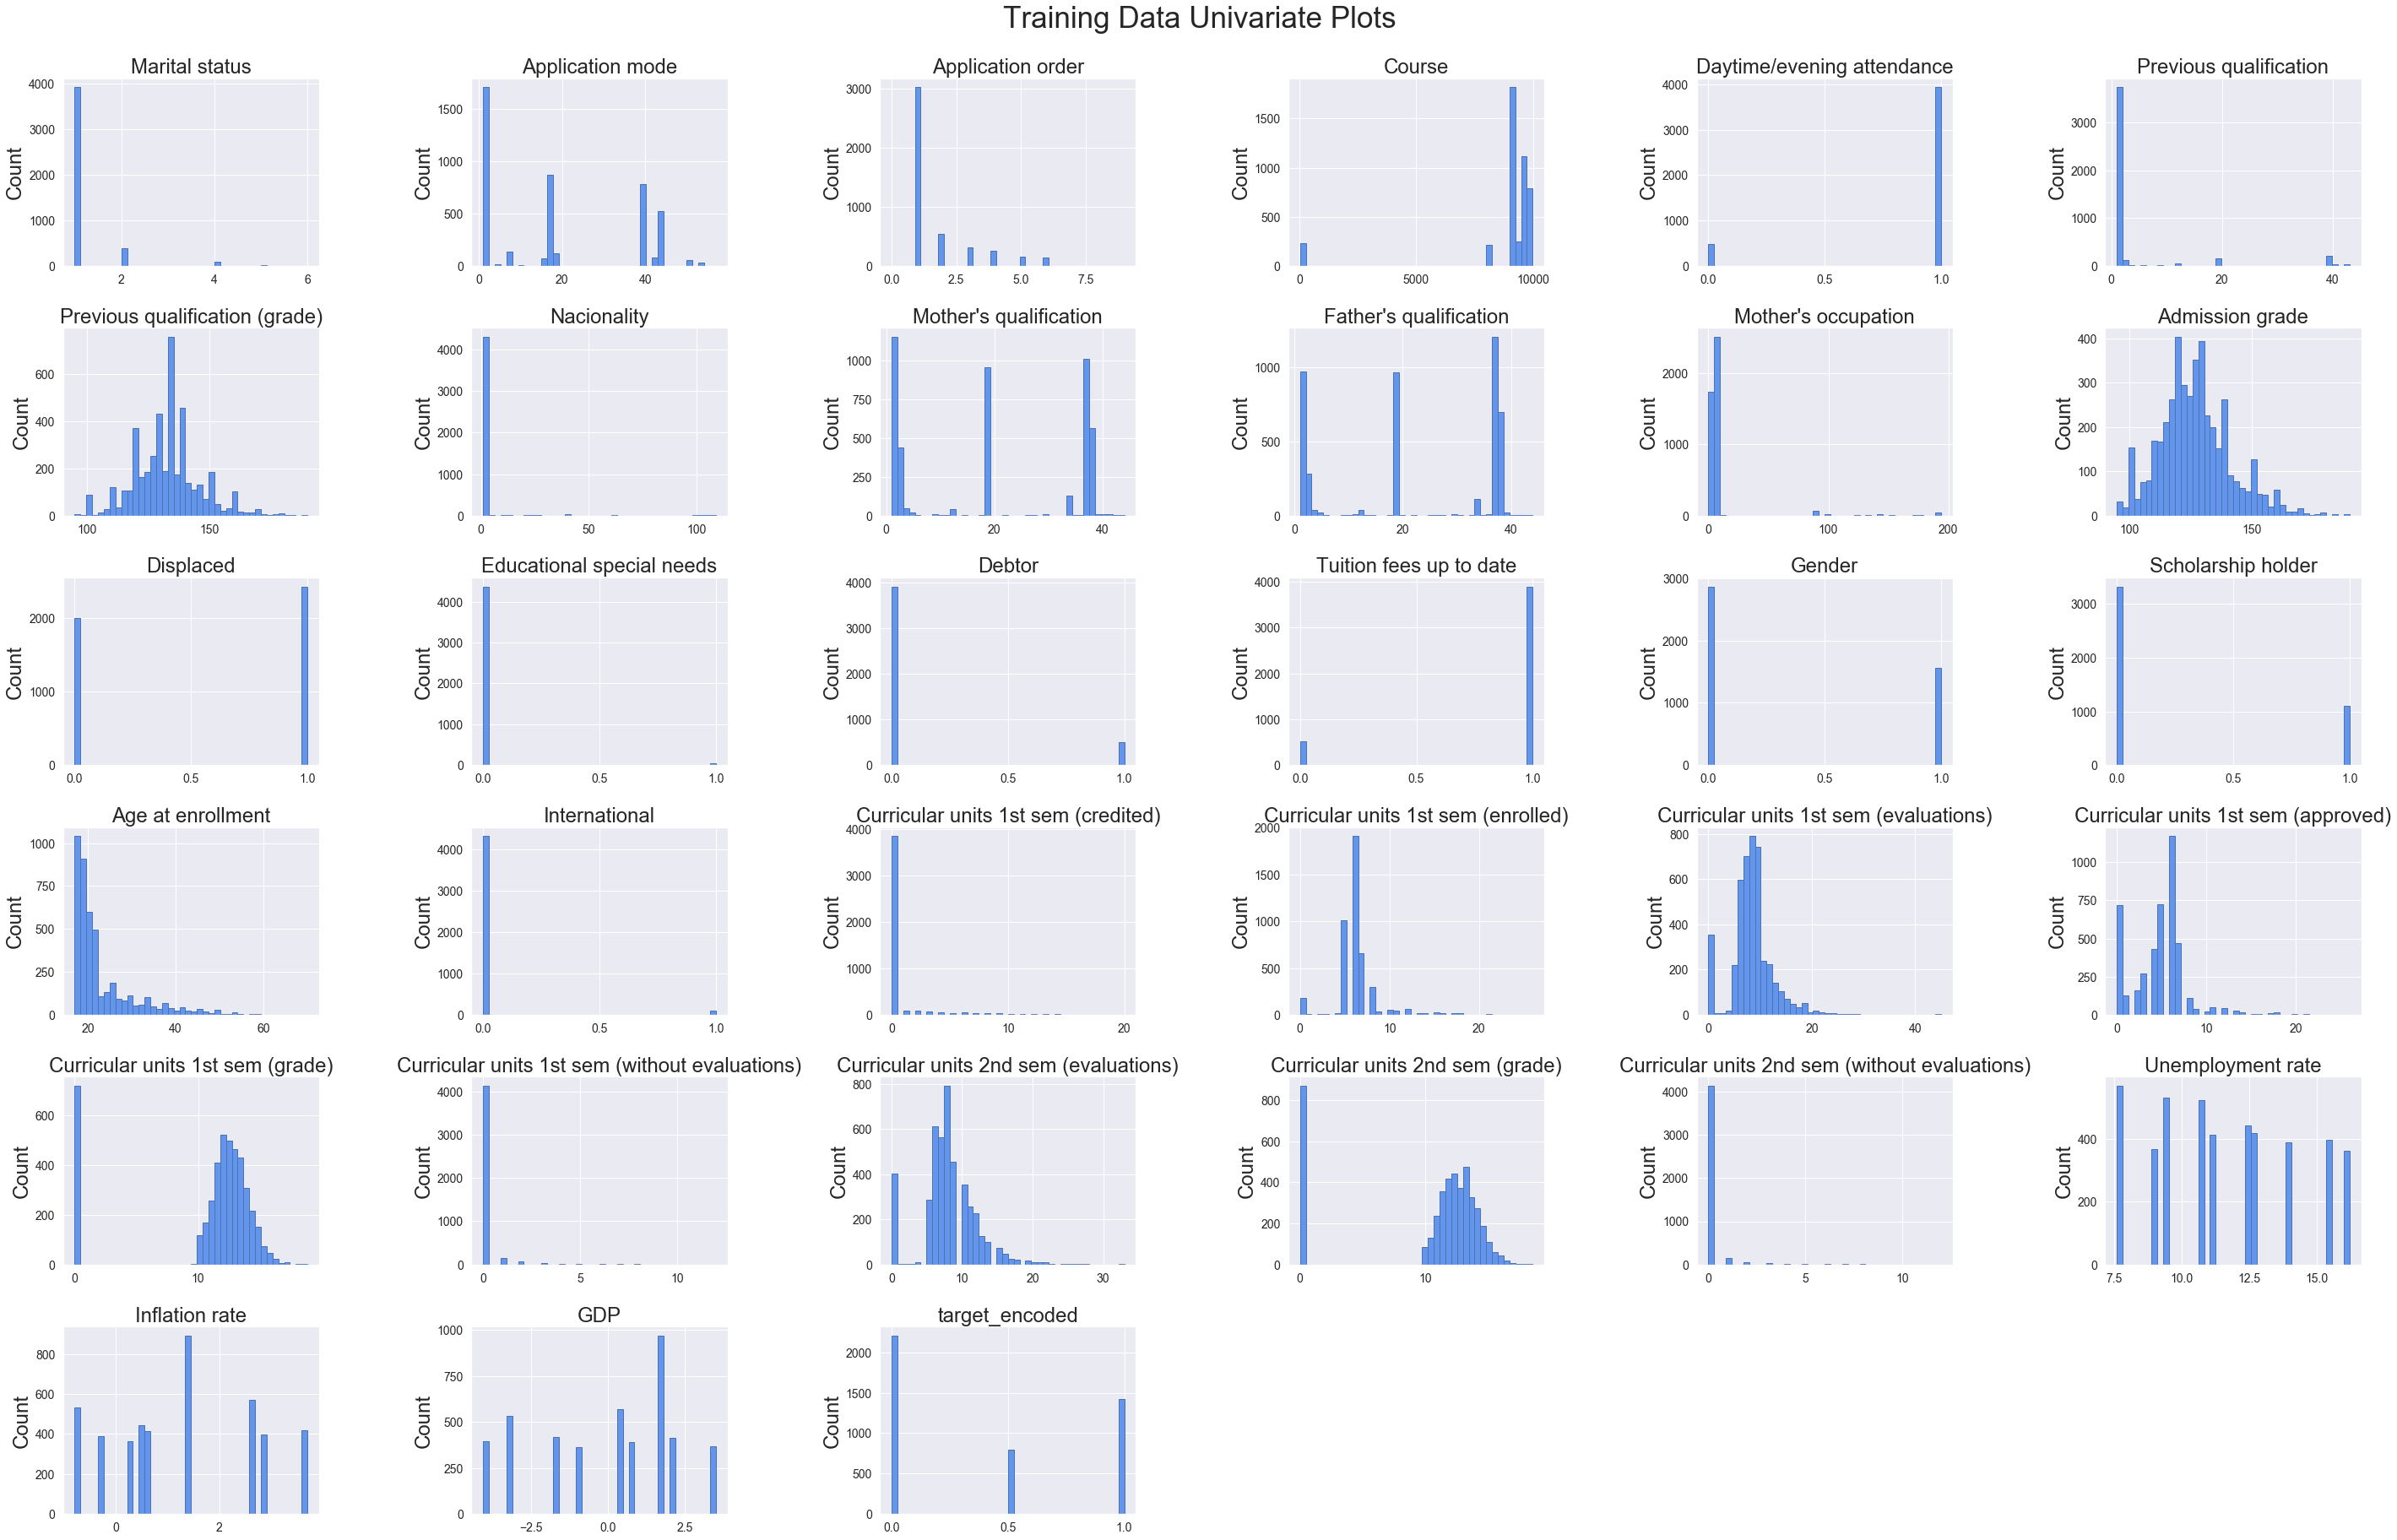

In [11]:
#Visualising feature distributions (ideally would need to rename large feature names in this example)
sns.set(font_scale=2)

axarr = selected_columns.hist(
    bins=40,
    edgecolor="b",
    linewidth=1.0,
    xlabelsize=14,
    ylabelsize=14,
    #grid=False,
    figsize=(40, 25),
    color="cornflowerblue",
)

for ax in axarr.flatten():
    ax.set_ylabel("Count")

plt.tight_layout()
plt.grid(axis="x", color="0.95")
plt.suptitle("Training Data Univariate Plots", y=1.02, fontsize=35)

The ```Course``` feature is very large, suggesting feature scaling is needed
- Although tree-based models are indifferent to feature scaling by their design (monotonic and binary decisions made inside decion trees make it so that the feature value cut-off point for each decision/branch in the tree should not change whether a feature is scaled or not)

In [12]:
selected_columns.drop(["target_encoded"], 1, inplace=True) #removing target variable (already stored in Y variable above)

In [13]:
scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(selected_columns), index=selected_columns.index, columns=selected_columns.columns)

## Additional Exploratory Data Analysis Options:
- Pairwise plots (difficult to plot in a ipynb markdown with many features)
- Mutual information gain 
- Partial dependence plots
- Principle Component Analysis


# Machine Learning (Using All Features)

In [14]:
#Hyper-parameter tuning of models:
#Model hyper-parameters are chosen based on trying to avoid overfitting (e.g. more branches/depth in a decision tree will give overfitting)
#But there is no one-size-fits-all range of parameters to test

xgbr = xgb.XGBRegressor(random_state=seed, objective='reg:squarederror') 
xgbr_params = {
    'max_depth':  (1, 4), 
    'learning_rate': (0.01, 0.2, 'log-uniform'),  
    'n_estimators':  (10, 50), 
    'reg_alpha':  (1, 10, 'log-uniform'), 
    'reg_lambda':  (1, 10, 'log-uniform')} 

catboost = CatBoostRegressor(random_seed=seed, verbose=False)
cat_params = {
     "iterations": (10, 50),
     'learning_rate': (0.01, 0.2, 'log-uniform'), 
     'depth':  (1, 4), 
}

#Set-up 5 divisions of train-test data for nested cross-validation (folds normally set at 5-10, the smaller the training data the less folds)

inner_cv = KFold(n_splits=5, shuffle=True, random_state=seed)
outer_cv = KFold(n_splits=5, shuffle=True, random_state=seed)

models = [] #Empty list

#Add models to the list:
models.append(("CB", BayesSearchCV(catboost, cat_params, cv=inner_cv, iid=False, n_jobs=1, random_state=seed)))
models.append(('XGBR', BayesSearchCV(xgbr, xgbr_params, cv=inner_cv, iid=False, n_jobs=1, random_state=seed))) 


In [15]:
#Empty lists to store model results to their names, a list of scoring metrics I want from sklearn, and an empty list to store best tuned r2 results
names = []
scoring = ['r2', 'neg_mean_squared_error', 'max_error', 'neg_mean_absolute_error',
          'explained_variance','neg_root_mean_squared_error',
           'neg_median_absolute_error'] 
models_list_r2 = []

In [16]:
#For loop iterating over one model at a time in the list, tuning its hyper-parameters on nested CV and printing its results

for name, model in models:
    nested_cv_results = model_selection.cross_validate(model, X_scaled, Y, cv=outer_cv, scoring=scoring, error_score="raise")
    names.append(name)
    median_r2 = np.median(nested_cv_results['test_r2'])
    print(name, 'Nested CV results for all scores:', '\n', nested_cv_results, '\n')
    print(name, 'r2 Nested CV Median', np.median(nested_cv_results['test_r2']))
    print(name, 'MSE Nested CV Median', np.median(nested_cv_results['test_neg_mean_squared_error'] ))
    print(name, 'RMSE Nested CV Median', np.median(nested_cv_results['test_neg_root_mean_squared_error'] ))
    print(name, 'Explained Variance Nested CV Median', np.median(nested_cv_results['test_explained_variance'] ))
    print(name, 'MAE Nested CV Median', np.median(nested_cv_results['test_neg_mean_absolute_error'] ))
    model.fit(dt, Y)
    print('\n')
    #printing the model's best hyper-parameters:
    print("Best Parameters: \n{}\n".format(model.best_params_))
    print("Best Estimator:", model.best_estimator_)
    best_model = model.best_estimator_
    #saving the top performing tuned model parameters with its r2
    models_list_r2.append((best_model,  median_r2))
    print('\n')


CB Nested CV results for all scores: 
 {'fit_time': array([83.24134398, 76.59515381, 84.13886976, 82.95228195, 75.96110582]), 'score_time': array([0.00699997, 0.00641012, 0.00644398, 0.00686002, 0.00709915]), 'test_r2': array([0.60724045, 0.57913775, 0.59566499, 0.56161076, 0.58256006]), 'test_neg_mean_squared_error': array([-0.07798199, -0.08455074, -0.07930743, -0.08368758, -0.08293968]), 'test_max_error': array([-0.99786613, -0.96082795, -0.9791495 , -0.93807692, -0.98103933]), 'test_neg_mean_absolute_error': array([-0.2104488 , -0.2087332 , -0.20517126, -0.21603766, -0.21144412]), 'test_explained_variance': array([0.60794884, 0.5823386 , 0.59571604, 0.56237018, 0.58271825]), 'test_neg_root_mean_squared_error': array([-0.27925256, -0.2907761 , -0.28161575, -0.28928806, -0.28799249]), 'test_neg_median_absolute_error': array([-0.15063269, -0.13623737, -0.14221191, -0.15167479, -0.14771573])} 

CB r2 Nested CV Median 0.5825600631895278
CB MSE Nested CV Median -0.08293967597522284
CB RM

In [17]:
best_model_tuned, best_r2 = sorted(models_list_r2, key = lambda x: x[1], reverse=True)[0]
print('Best model by median r2:', best_model_tuned)

Best model by median r2: XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.2, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=1, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=50, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=1,
             reg_lambda=1, ...)


# Feature Selection (BorutaShap method)
- BorutaShap uses a model to select features
- Model input into feature selection is the top performing model from previous testing with all features

In [18]:
Feature_Selector = BorutaShap(model=best_model_tuned, importance_measure="shap", classification=False)

Feature_Selector.fit(X= X_scaled, y=Y, n_trials=100, random_state=seed)

subset = Feature_Selector.Subset()
X = subset

  0%|          | 0/100 [00:00<?, ?it/s]

13 attributes confirmed important: ['Admission grade', 'Curricular units 1st sem (evaluations)', 'Tuition fees up to date', 'Curricular units 1st sem (approved)', 'Curricular units 2nd sem (grade)', 'Curricular units 2nd sem (evaluations)', 'Scholarship holder', 'Curricular units 1st sem (grade)', 'Age at enrollment', 'Curricular units 1st sem (enrolled)', 'Debtor', 'Gender', 'Course']
19 attributes confirmed unimportant: ['Application mode', 'Daytime/evening attendance', 'Displaced', 'Unemployment rate', 'Previous qualification', "Father's qualification", 'Inflation rate', 'Curricular units 1st sem (without evaluations)', "Mother's qualification", 'Curricular units 1st sem (credited)', 'Previous qualification (grade)', 'Educational special needs', "Mother's occupation", 'Nacionality', 'GDP', 'Curricular units 2nd sem (without evaluations)', 'Application order', 'International', 'Marital status']
0 tentative attributes remains: []


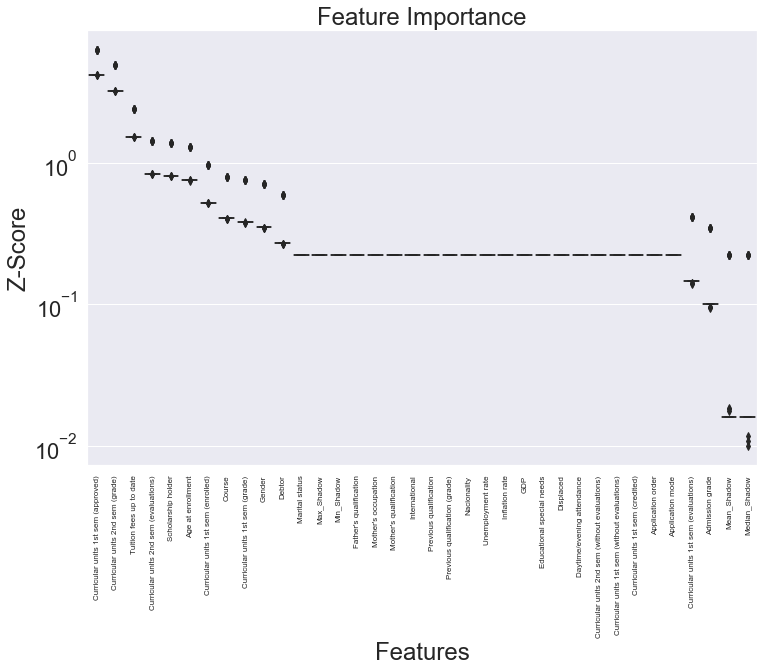

In [19]:
sns.set_style("darkgrid")
sns.mpl.rcParams["figure.figsize"] = (18, 20)
Feature_Selector.plot(which_features="all") 
#This is meant to produce boxplots - likely this data is better for classification rather than the regression I have forced it to be

In [20]:
# Repeat machine learning benchmarking with selected features to see if this improves results:
for name, model in models:
    nested_cv_results = model_selection.cross_validate(model, X, Y, cv=outer_cv, scoring=scoring, error_score="raise")
    names.append(name)
    print(name, 'Nested CV results for all scores:', '\n', nested_cv_results, '\n')
    print(name, 'r2 Nested CV Median', np.median(nested_cv_results['test_r2']))
    print(name, 'MSE Nested CV Median', np.median(nested_cv_results['test_neg_mean_squared_error'] ))
    print(name, 'RMSE Nested CV Median', np.median(nested_cv_results['test_neg_root_mean_squared_error'] ))
    print(name, 'Explained Variance Nested CV Median', np.median(nested_cv_results['test_explained_variance'] ))
    print(name, 'MAE Nested CV Median', np.median(nested_cv_results['test_neg_mean_absolute_error'] ))
    model.fit(X, Y)
    print('\n')
    print("Best Parameters: \n{}\n".format(model.best_params_))
    print("Best Estimator:", model.best_estimator_)
    best_model = model.best_estimator_
    best_model.fit(X, Y)
    models_list_r2.append((best_model,  median_r2))
    print('\n')

CB Nested CV results for all scores: 
 {'fit_time': array([72.88384008, 73.80759716, 73.53805494, 71.39518476, 77.1528089 ]), 'score_time': array([0.00498414, 0.00466204, 0.00461817, 0.00483108, 0.0047102 ]), 'test_r2': array([0.62061329, 0.58294197, 0.6045985 , 0.56532821, 0.59220467]), 'test_neg_mean_squared_error': array([-0.07532683, -0.08378648, -0.07755519, -0.08297793, -0.08102342]), 'test_max_error': array([-0.97142655, -0.99120378, -1.00992424, -0.97549704, -0.99353778]), 'test_neg_mean_absolute_error': array([-0.20324024, -0.20545975, -0.20136509, -0.21059177, -0.20496659]), 'test_explained_variance': array([0.6217428 , 0.58580141, 0.60463527, 0.56572273, 0.5924322 ]), 'test_neg_root_mean_squared_error': array([-0.27445734, -0.28945894, -0.27848732, -0.2880589 , -0.28464614]), 'test_neg_median_absolute_error': array([-0.13708013, -0.13469265, -0.1460293 , -0.14711873, -0.13743804])} 

CB r2 Nested CV Median 0.5922046675479526
CB MSE Nested CV Median -0.08102342338446951
CB RM

In [21]:
best_model_tuned, best_r2 = sorted(models_list_r2, key = lambda x: x[1], reverse=True)[0]
print('Best model by median r2:', best_model_tuned)

Best model by median r2: XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.2, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=1, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=50, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=1,
             reg_lambda=1, ...)


## Interpreting Model Decision-making
- XGBoost was the top performing model (although performance is poor and feature selection doesn't improve performance in this case, this is likely due to forcing data that was curated as a classification problem into a regression one - data with a better continuous target variable, such as using student enrollment status over time points, or different features may perform better)

- SHAP package can visualise how the model values each feature for each student in its decision-making

In [22]:
#Fitting model with the best hyper-parameter tuning:
xgb_model = xgb.XGBRegressor(learning_rate=0.2, max_depth=1, n_estimators=50, 
                         random_state=0, reg_alpha=1, reg_lambda=1, objective="reg:squarederror")

xgb_model.fit(X, Y)

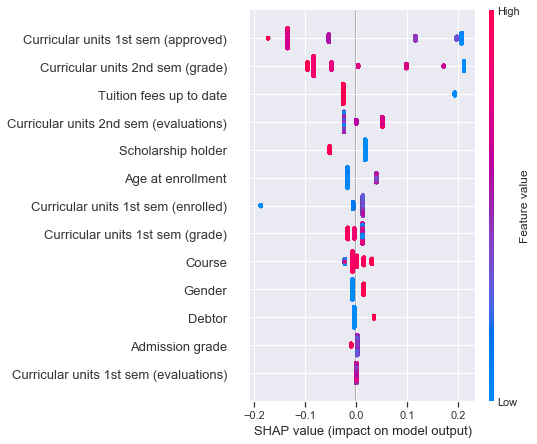

In [23]:
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X)

#Each point in the point represents a student
#How the points/students are grouped and not spread out shows how the data in this case would be better as a multiclass classification problem

- More examples of SHAP with clear regression analysis interpretation can be found here: https://github.com/hlnicholls/SHAP-reference